# Predictive Insights Youth Income Prediction Challenge


https://zindi.africa/competitions/predictive-insights-youth-income-prediction-challenge/datahttps://zindi.africa/competitions/predictive-insights-youth-income-prediction-challenge/data

# 1. CLASSIFICATION MODEL

# a) fEATURES PRE-PROCESSING

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Load dataset
Train = read_csv("Train.csv")
Test = read_csv("Test.csv")

# Combine the two DataFrames into one
dataset = pd.concat([Train, Test], axis=0)

# Set index
dataset = dataset.set_index('Person_id')  # <-- It was wrongly written as 'dataset'

# Add 'Year_survey' and 'Age_survey' columns
dataset['Year_survey'] = pd.to_datetime(dataset['Survey_date']).dt.year
dataset['Age_survey'] = dataset['Year_survey'] - dataset['Birthyear']

# Create 'Subjects_over_70' column
dataset['Subjects_over_70'] = dataset.apply(lambda row: row.astype(str).str.contains("80 - 100 %|70 - 79 %").sum(), axis=1)

# Create a list of selected categorical variables
selected_vars = ["Round", "Status", "Geography", "Province",
                 "Schoolquintile", "Math", "Mathlit", "Additional_lang", "Home_lang", "Science"]

# Remove columns we won't use
dataset = dataset.drop(["Survey_date"], axis=1)  # 'Person_id' was already dropped by setting the index

# Convert categorical variables to dummy variables
dataset1 = pd.get_dummies(dataset, columns=selected_vars, drop_first=True, dummy_na=True)

# Fill missing values with zero
dataset1 = dataset1.fillna(0)

# Split back into Train and Test
Test_dataset1 = dataset1.tail(1934)  # Test dataset
Test_dataset1 = Test_dataset1.drop('Target', axis=1)

Train_dataset1 = dataset1.iloc[:-1934]  # Train dataset

# Separate features and target
X = Train_dataset1.drop('Target', axis=1)
y = Train_dataset1['Target']

# Define models dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Define 12-fold cross-validation
cv = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)

C:\Users\43197\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


# b) ROC AUC and Confusion Matrix

In [88]:
def plot_roc_curve_and_confusion_matrix(model_name, X, y, models, cv):
    """
    Plots ROC curve and Confusion Matrix for a specified model using 12-fold cross-validation.

    :param model_name: The model name as a string (should match key in 'models' dictionary)
    :param X: Features dataset (pandas DataFrame)
    :param y: Target dataset (pandas Series)
    :param models: Dictionary containing model names and corresponding sklearn model objects
    :param cv: Cross-validation strategy (StratifiedKFold in this case)
    """
    if model_name not in models:
        print(f"Model '{model_name}' not found. Available models: {list(models.keys())}")
        return

    model = models[model_name]
    print(f"\n{'='*10} {model_name} {'='*10}")

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # Store confusion matrices
    cm_total = np.zeros((2, 2))  # Confusion matrix initialized to zero

    plt.figure(figsize=(10, 8))

    # Cross-validation loop
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train_cv, y_train_cv)
        y_probs = model.predict_proba(X_test_cv)[:, 1]
        y_pred = model.predict(X_test_cv)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_cv, y_probs)
        auc_score = roc_auc_score(y_test_cv, y_probs)

        aucs.append(auc_score)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        # Plot ROC curve for each fold
        plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {fold_idx} (AUC = {auc_score:.2f})')

        # Print AUC for each fold
        print(f"Fold {fold_idx}: AUC = {auc_score:.4f}")

        # Calculate confusion matrix for each fold
        cm = confusion_matrix(y_test_cv, y_pred)
        cm_total += cm

    # Mean ROC curve across all folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color='black',
             label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    plt.title(f'ROC Curves for All 12 Folds: {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Plot the average confusion matrix
    cm_avg = cm_total / cv.get_n_splits()
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_avg, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f'Average Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()





========== XGBoost ==========
Fold 1: AUC = 0.8727
Fold 2: AUC = 0.8495
Fold 3: AUC = 0.8450
Fold 4: AUC = 0.8781
Fold 5: AUC = 0.8486
Fold 6: AUC = 0.8407
Fold 7: AUC = 0.8636
Fold 8: AUC = 0.8618
Fold 9: AUC = 0.8577
Fold 10: AUC = 0.8384
Fold 11: AUC = 0.8739
Fold 12: AUC = 0.8747


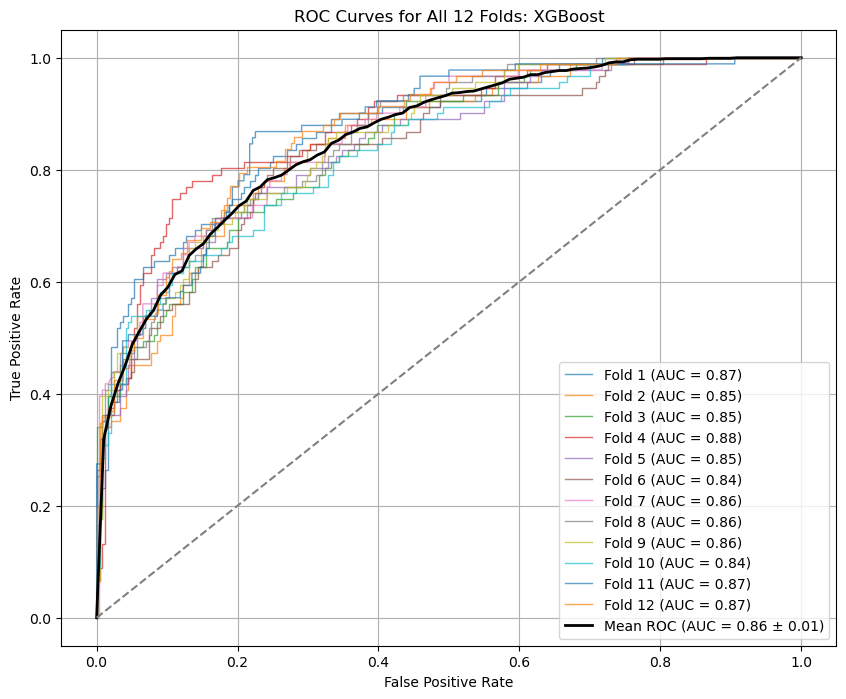

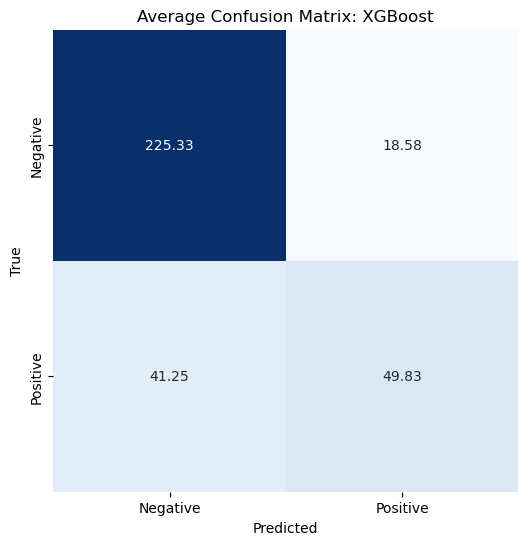

In [89]:
# plot ROC curve and Confusion Matrix for XGBoost
plot_roc_curve_and_confusion_matrix("XGBoost", X, y, models, cv)


========== Decision Tree ==========
Fold 1: AUC = 0.7161
Fold 2: AUC = 0.7352
Fold 3: AUC = 0.7476
Fold 4: AUC = 0.7314
Fold 5: AUC = 0.7475
Fold 6: AUC = 0.7237
Fold 7: AUC = 0.7211
Fold 8: AUC = 0.7415
Fold 9: AUC = 0.7257
Fold 10: AUC = 0.7227
Fold 11: AUC = 0.7113
Fold 12: AUC = 0.7052


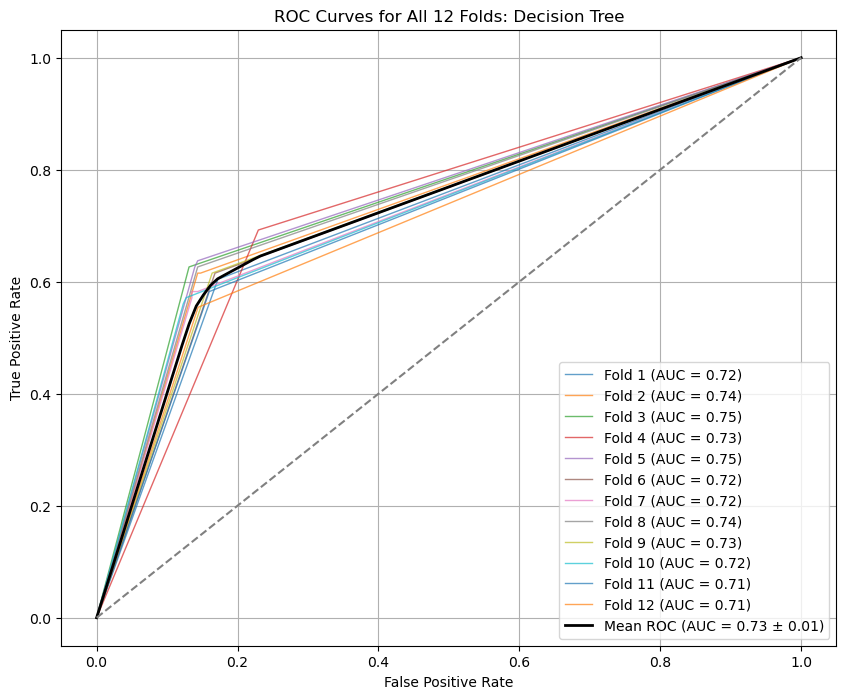

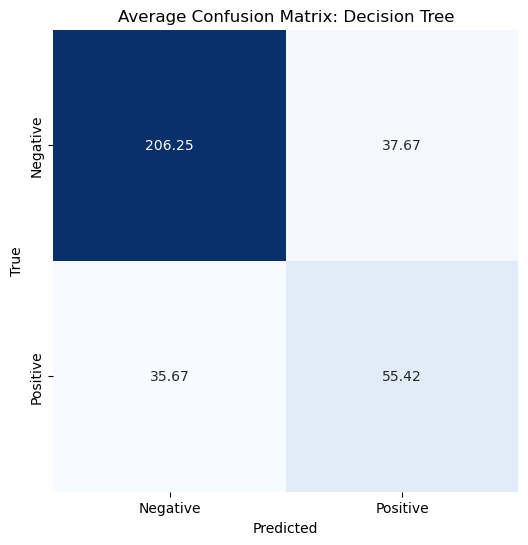

In [90]:
# Plot ROC for DECISION TREE
plot_roc_curve_and_confusion_matrix("Decision Tree", X, y, models, cv)


========== Random Forest ==========
Fold 1: AUC = 0.8478
Fold 2: AUC = 0.8064
Fold 3: AUC = 0.7905
Fold 4: AUC = 0.8505
Fold 5: AUC = 0.8355
Fold 6: AUC = 0.8055
Fold 7: AUC = 0.8398
Fold 8: AUC = 0.8316
Fold 9: AUC = 0.8304
Fold 10: AUC = 0.7945
Fold 11: AUC = 0.8179
Fold 12: AUC = 0.8358


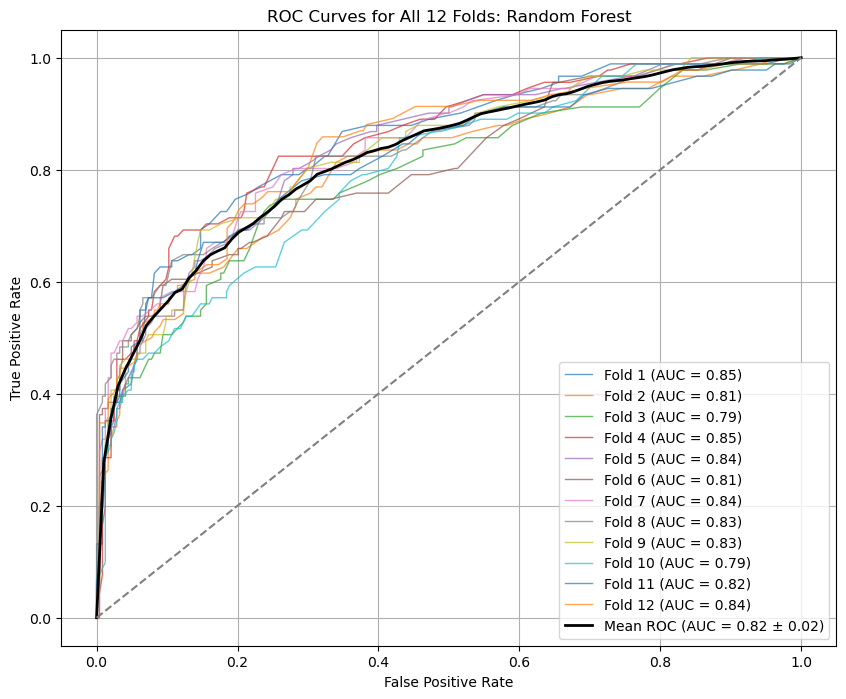

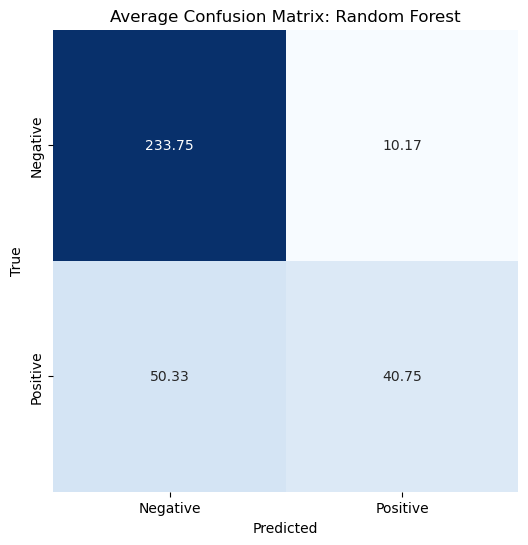

In [91]:
# Plot ROC for Random Forest
plot_roc_curve_and_confusion_matrix("Random Forest", X, y, models, cv)


========== Logistic Regression ==========
Fold 1: AUC = 0.8338
Fold 2: AUC = 0.7856
Fold 3: AUC = 0.7602
Fold 4: AUC = 0.8267
Fold 5: AUC = 0.7872
Fold 6: AUC = 0.8140
Fold 7: AUC = 0.8414
Fold 8: AUC = 0.8187
Fold 9: AUC = 0.8237
Fold 10: AUC = 0.7700
Fold 11: AUC = 0.8304
Fold 12: AUC = 0.7952


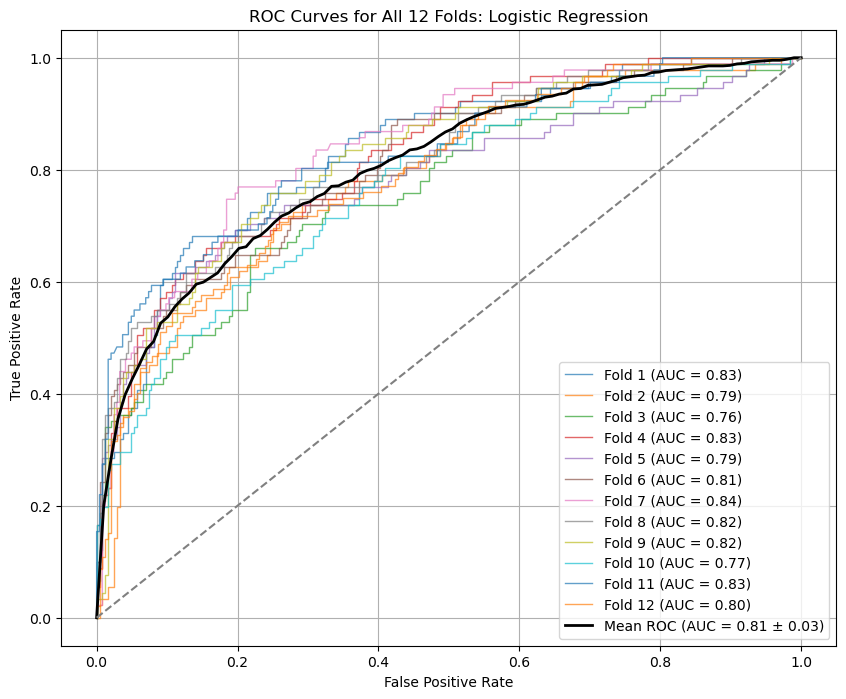

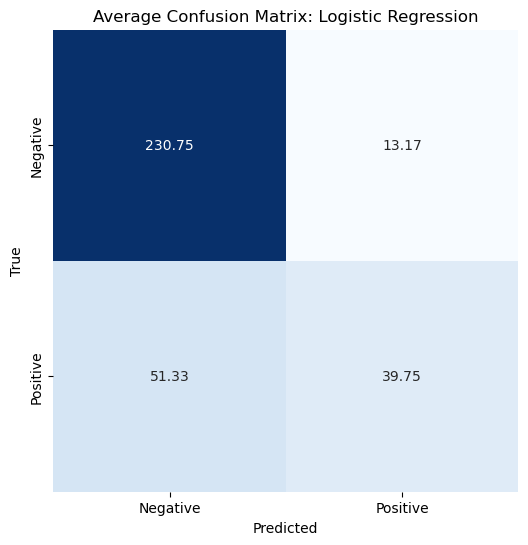

In [92]:
# Plot ROC for lOGISTIC REGRESSION
plot_roc_curve_and_confusion_matrix("Logistic Regression", X, y, models, cv)


========== KNN Classifier ==========
Fold 1: AUC = 0.7148
Fold 2: AUC = 0.6339
Fold 3: AUC = 0.6554
Fold 4: AUC = 0.7534
Fold 5: AUC = 0.6437
Fold 6: AUC = 0.6976
Fold 7: AUC = 0.6698
Fold 8: AUC = 0.7138
Fold 9: AUC = 0.7243
Fold 10: AUC = 0.6506
Fold 11: AUC = 0.6762
Fold 12: AUC = 0.6959


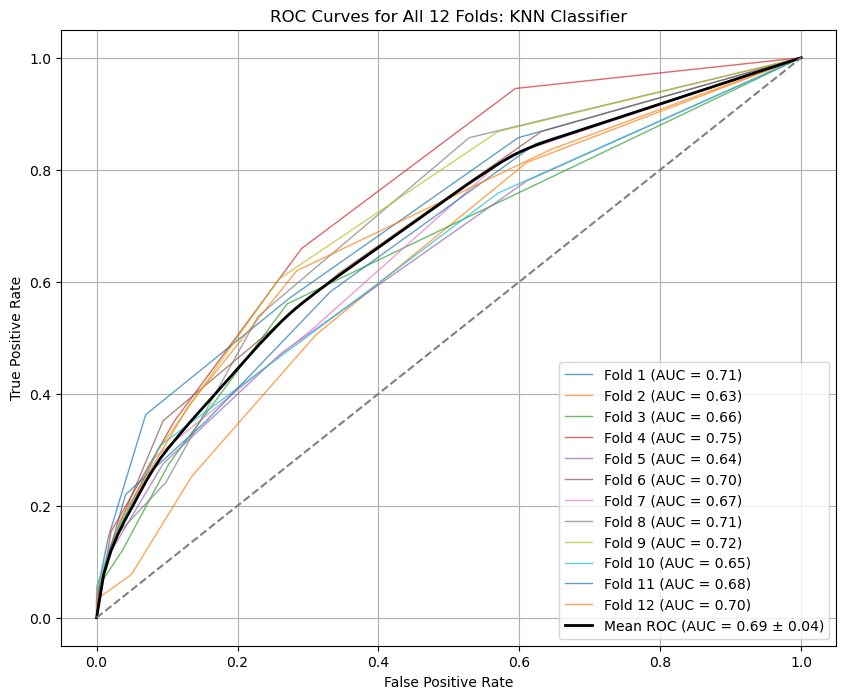

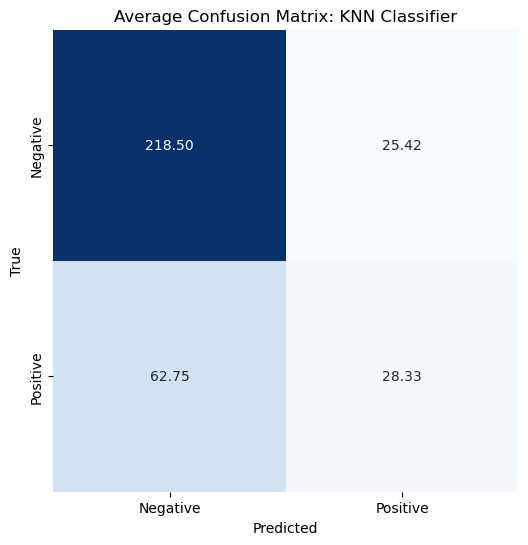

In [93]:
# Plot ROC for KNN Classifier
plot_roc_curve_and_confusion_matrix("KNN Classifier", X, y, models, cv)


========== XGBoost ==========
Fold 1: AUC = 0.8727
Fold 2: AUC = 0.8495
Fold 3: AUC = 0.8450
Fold 4: AUC = 0.8781
Fold 5: AUC = 0.8486
Fold 6: AUC = 0.8407
Fold 7: AUC = 0.8636
Fold 8: AUC = 0.8618
Fold 9: AUC = 0.8577
Fold 10: AUC = 0.8384
Fold 11: AUC = 0.8739
Fold 12: AUC = 0.8747


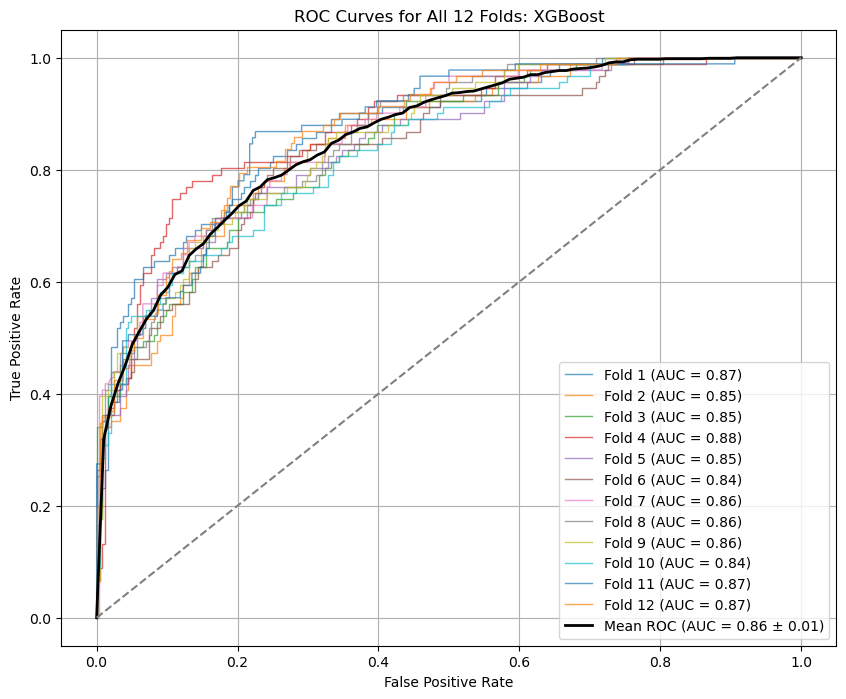

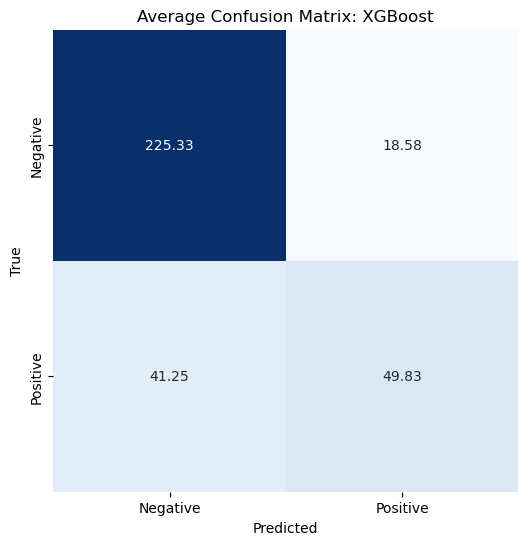

In [94]:
# Plot ROC for XGBoost
plot_roc_curve_and_confusion_matrix("XGBoost", X, y, models, cv)

# Target Class prediction

In [95]:

# Predict the target for Test_df1 using the selected model (e.g., Logistic Regression)
model_name = "Logistic Regression"  # You can change this to any model in the dictionary

# Check if the model exists
if model_name in models:
    model = models[model_name]
    
    # Fit the model on the training data (using your full training data X and y)
    model.fit(X, y)
    
    # Prepare the test data (make sure no extra columns like 'Target' are in the features)
    X_test = Test_df1.drop(columns=['Target', 'Predicted_Target'], errors='ignore')
    
    # Ensure the feature columns of X_test match those used in training
    if list(X.columns) != list(X_test.columns):
        raise ValueError("Feature columns in X_test do not match those in the training data.")
    
    # Make predictions on the `Test_df1` dataset
    predictions = model.predict(X_test)
    
    # Add the predictions as a new column in `Test_df1`
    Test_df1['Predicted_Target'] = predictions
    
    # If you want to see the predictions
    print(Test_df1[['Predicted_Target']].head())  # Display first few rows of predictions
    
else:
    print(f"Model '{model_name}' not found. Available models: {list(models.keys())}")


               Predicted_Target
Person_id                      
Id_r90136smvl               1.0
Id_wawdqhmu6s               0.0
Id_ap2czff2bu               0.0
Id_uhgink7iha               0.0
Id_5j6bzk3k81               0.0


# 2.REGRESSION


========== XGBoost ==========
Fold 1: R2 = 0.3726, MSE = 0.1241
Fold 2: R2 = 0.2902, MSE = 0.1404
Fold 3: R2 = 0.3081, MSE = 0.1369
Fold 4: R2 = 0.3597, MSE = 0.1267
Fold 5: R2 = 0.3167, MSE = 0.1352
Fold 6: R2 = 0.3263, MSE = 0.1333
Fold 7: R2 = 0.3590, MSE = 0.1268
Fold 8: R2 = 0.3762, MSE = 0.1234
Fold 9: R2 = 0.3431, MSE = 0.1300
Fold 10: R2 = 0.2611, MSE = 0.1462
Fold 11: R2 = 0.3243, MSE = 0.1337
Fold 12: R2 = 0.3256, MSE = 0.1344


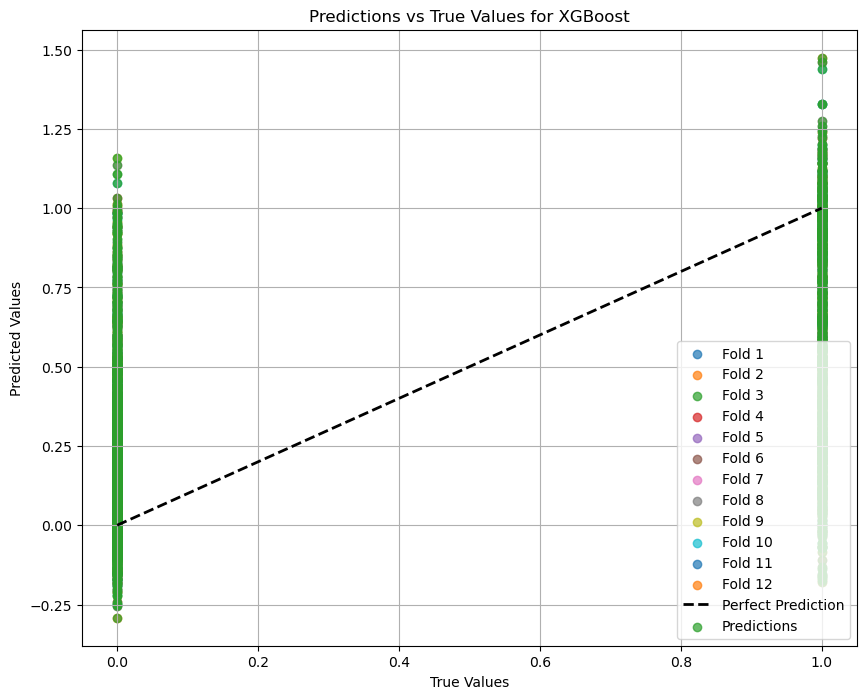

               Predicted_Target
Person_id                      
Id_r90136smvl          0.784878
Id_wawdqhmu6s          0.135044
Id_ap2czff2bu          0.046101
Id_uhgink7iha          0.162112
Id_5j6bzk3k81          0.125334


In [96]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Define models dictionary for regression
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Define 12-fold cross-validation
cv = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)

def plot_regression_model(model_name, X, y, models, cv):
    """
    Plots the predictions vs true values for a specified regression model using 12-fold cross-validation.

    :param model_name: The model name as a string (should match key in 'models' dictionary)
    :param X: Features dataset (pandas DataFrame)
    :param y: Target dataset (pandas Series)
    :param models: Dictionary containing model names and corresponding sklearn model objects
    :param cv: Cross-validation strategy (StratifiedKFold in this case)
    """
    if model_name not in models:
        print(f"Model '{model_name}' not found. Available models: {list(models.keys())}")
        return

    model = models[model_name]
    print(f"\n{'='*10} {model_name} {'='*10}")

    # Store predictions and true values for plotting
    all_true = []
    all_pred = []

    plt.figure(figsize=(10, 8))

    # Cross-validation loop
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)

        all_true.extend(y_test_cv)
        all_pred.extend(y_pred)

        # Plot predictions vs true values for each fold
        plt.scatter(y_test_cv, y_pred, alpha=0.7, label=f'Fold {fold_idx}')

        # Print R2 score and MSE for each fold
        r2 = r2_score(y_test_cv, y_pred)
        mse = mean_squared_error(y_test_cv, y_pred)
        print(f"Fold {fold_idx}: R2 = {r2:.4f}, MSE = {mse:.4f}")

    # Plot all true vs predicted values
    plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], color='black', lw=2, linestyle='--', label='Perfect Prediction')
    plt.scatter(all_true, all_pred, alpha=0.7, label='Predictions')

    plt.title(f'Predictions vs True Values for {model_name}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Example usage: Call the function to plot regression results for XGBoost
plot_regression_model("XGBoost", X, y, models, cv)

# Predict the target for Test_dataset1 using the selected regression model (e.g., Linear Regression)
model_name = "Linear Regression"  # You can change this to any model in the dictionary

# Check if the model exists
if model_name in models:
    model = models[model_name]
    
    # Fit the model on the training data (using your full training data X and y)
    model.fit(X, y)
    
    # Prepare the test data (make sure no extra columns like 'Target' are in the features)
    X_test = Test_dataset1.drop(columns=['Target', 'Predicted_Target'], errors='ignore')
    
    # Ensure the feature columns of X_test match those used in training
    if list(X.columns) != list(X_test.columns):
        raise ValueError("Feature columns in X_test do not match those in the training data.")
    
    # Make predictions on the `Test_dataset1` dataset
    predictions = model.predict(X_test)
    
    # Add the predictions as a new column in `Test_dataset1`
    Test_dataset1['Predicted_Target'] = predictions
    
    # If you want to see the predictions
    print(Test_dataset1[['Predicted_Target']].head())  # Display first few rows of predictions
    
else:
    print(f"Model '{model_name}' not found. Available models: {list(models.keys())}")
